In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import CountFrequencyEncoder, RareLabelEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures

from sklearn.preprocessing import StandardScaler

#### Cargamos los datos

In [2]:
dataTrain=pd.read_csv('train.csv')
dataTrain.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


#### 1. Determine que columnas poseen faltantes (NA o Nulos)

In [3]:
col_NA = [col for col in dataTrain.columns if (dataTrain [col].isnull().mean()> 0)]
col_NA

['total_bedrooms']

In [4]:
dataTrain.isnull().any()

id                    False
longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

#### 2. Determine la proporción de faltantes para cada columna con faltantes, muestre una gráfica de barras.

In [5]:
prop_nan = dataTrain [col_NA].isnull().mean()
prop_nan

total_bedrooms    0.009483
dtype: float64

<AxesSubplot:>

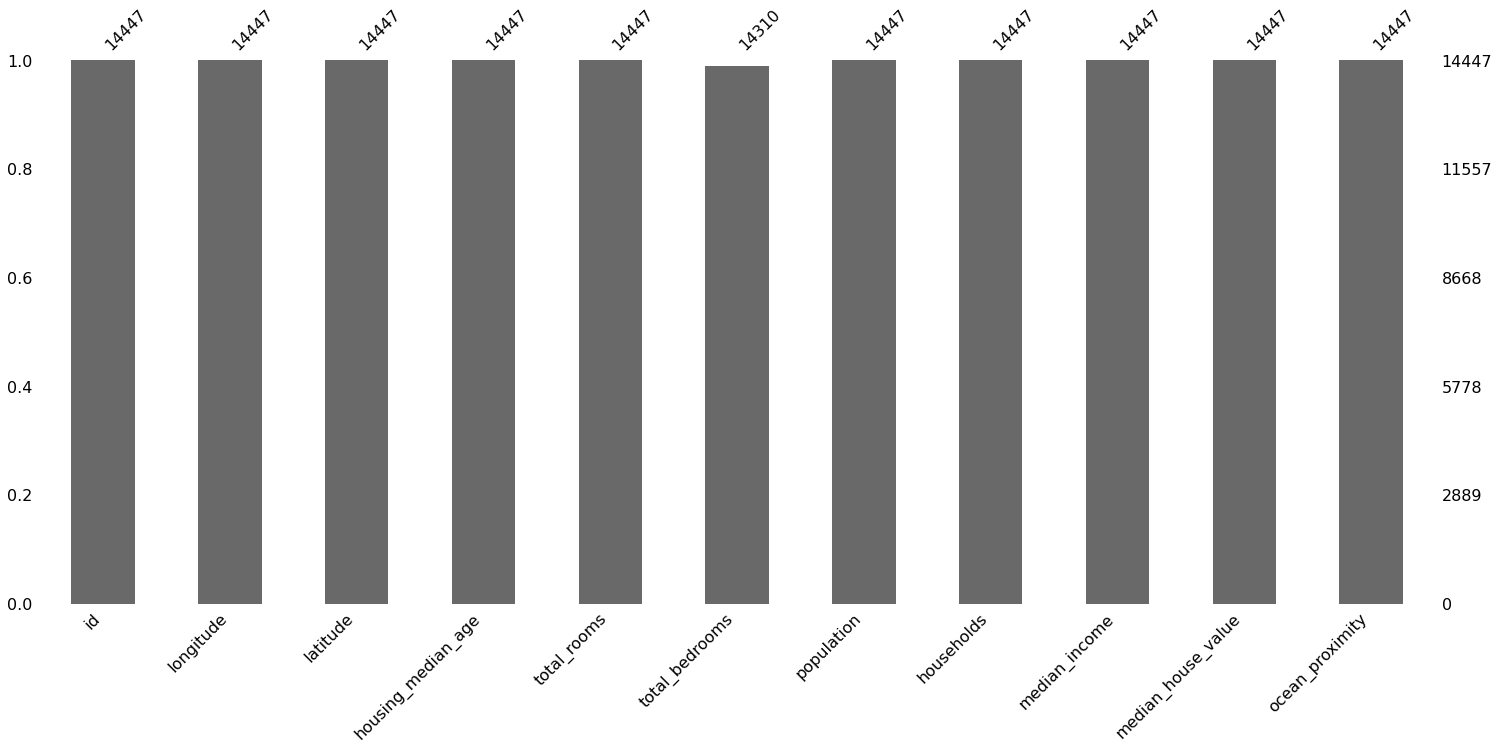

In [6]:
import missingno as msno
dataTrain.isna().sum()
msno.bar(dataTrain)

#### 3. Si la variable es numérica realice un análisis de cual sería el mejor método para realizar la imputación de datos, debe mostrar un bloque de código donde se muestre cada imputación y su análisis. Recuerde que puede ser: 

##### a. Eliminar los faltantes

In [7]:
dataTrain [col_NA].dtypes

total_bedrooms    float64
dtype: object

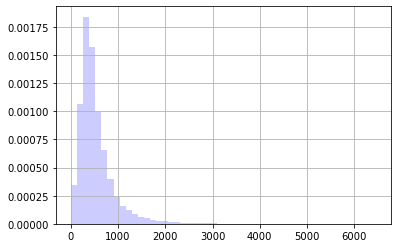

In [8]:
dataTrain['total_bedrooms'].hist(bins=50, density=True, color='blue',alpha=0.2)
plt.show()

##### b. Imputación de media o mediana

In [9]:
media = dataTrain['total_bedrooms'].mean()
mediana = dataTrain['total_bedrooms'].median()

print(f"Media:{media}")
print(f"Median:{mediana}")

Media:537.7787561146051
Median:433.0


In [10]:
dataTrain['total_bedrooms_media'] = np.round(dataTrain['total_bedrooms'].fillna(media))
dataTrain['total_bedrooms_median'] = np.round(dataTrain['total_bedrooms'].fillna(mediana))

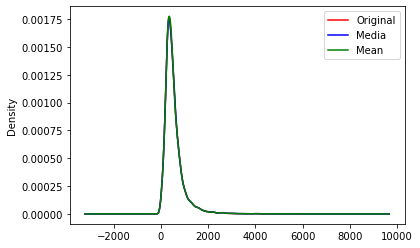

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

dataTrain['total_bedrooms'].plot.density(color='red',label='Original')
dataTrain['total_bedrooms_media'].plot.density(color='blue',label='Media')
dataTrain['total_bedrooms_median'].plot.density(color='green',label='Mean')
ax.legend()

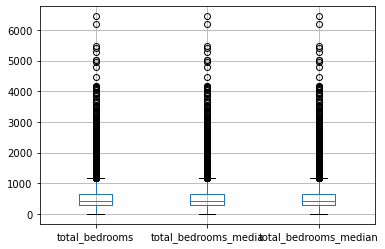

In [12]:
dataTrain[['total_bedrooms', 'total_bedrooms_media', 'total_bedrooms_median']].boxplot()
plt.show()

##### c. Valores arbitrarios (extremo derecho y extremo izquierdo)

In [13]:
dataset=dataTrain
col='total_bedrooms'

def detectLimits(dataTrain,col):
    """ Descripción calcula los limites superiores e inferiores para detección de outliers.
input: dataset-> pandas dataframe, col-> string nombre de columna
output: tupla de floats con los limites superior e inferior"""

    IQR=dataTrain[col].quantile(0.75)-dataset[col].quantile(0.25)
    LI=dataTrain[col].quantile(0.25)-(IQR*1.75)
    LS=dataTrain[col].quantile(0.75)+(IQR*1.75)

    return LI, LS

In [14]:
LI, LS = detectLimits(dataTrain, 'total_bedrooms')
LI, LS

(-321.0, 1263.0)

#### 5. Realice la codificación de variables categóricas, determine cual es le mejor enfoque para cada caso, recuerde que puede realizar los siguientes enfoques:


##### a. One Hote Encodign.

In [15]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14447 non-null  int64  
 1   longitude              14447 non-null  float64
 2   latitude               14447 non-null  float64
 3   housing_median_age     14447 non-null  int64  
 4   total_rooms            14447 non-null  int64  
 5   total_bedrooms         14310 non-null  float64
 6   population             14447 non-null  int64  
 7   households             14447 non-null  int64  
 8   median_income          14447 non-null  float64
 9   median_house_value     14447 non-null  float64
 10  ocean_proximity        14447 non-null  object 
 11  total_bedrooms_media   14447 non-null  float64
 12  total_bedrooms_median  14447 non-null  float64
dtypes: float64(7), int64(5), object(1)
memory usage: 1.4+ MB


In [16]:
dataTrain_cat =dataTrain[["ocean_proximity","median_income"]]
dataTrain_cat.head()

,ocean_proximity,median_income
0,<1H OCEAN,4.7969
1,INLAND,3.7292
2,<1H OCEAN,7.3561
3,NEAR BAY,10.2264
4,<1H OCEAN,2.5784


In [17]:
dataTrain_cat['ocean_proximity'].value_counts()

<1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64

In [18]:
pd.get_dummies(dataTrain_cat['ocean_proximity'])

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,1,0
4,1,0,0,0,0
...,...,...,...,...,...
14442,0,0,0,1,0
14443,0,0,0,0,1
14444,0,1,0,0,0
14445,0,1,0,0,0


In [19]:
dfTemp=pd.get_dummies(dataTrain_cat)
dfTemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_income               14447 non-null  float64
 1   ocean_proximity_<1H OCEAN   14447 non-null  uint8  
 2   ocean_proximity_INLAND      14447 non-null  uint8  
 3   ocean_proximity_ISLAND      14447 non-null  uint8  
 4   ocean_proximity_NEAR BAY    14447 non-null  uint8  
 5   ocean_proximity_NEAR OCEAN  14447 non-null  uint8  
dtypes: float64(1), uint8(5)
memory usage: 183.5 KB


##### b. Codificación por Frecuencia.

In [20]:
dataTrain['ocean_proximity'].value_counts().sort_values(ascending=False)

<1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64

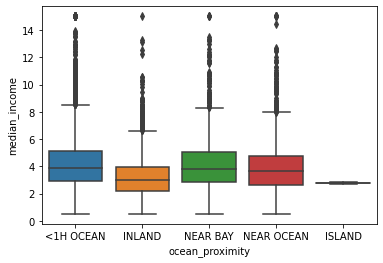

In [21]:
import seaborn as sns
sns.boxplot(x=dataTrain_cat['ocean_proximity'], y=dataTrain_cat['median_income'])
plt.show()

In [22]:
ocean_freq = (dataTrain_cat['ocean_proximity'].value_counts().sort_values(ascending=False)).to_dict()
ocean_freq

{'<1H OCEAN': 6384,
 'INLAND': 4577,
 'NEAR OCEAN': 1865,
 'NEAR BAY': 1619,
 'ISLAND': 2}

In [23]:
dataTrain_cat['ocean_proximity_code'] = dataTrain_cat['ocean_proximity'].map(ocean_freq)
dataTrain_cat[['ocean_proximity', 'ocean_proximity_code']]

C:\Users\Andrea\AppData\Local\Temp\ipykernel_15776\3641064559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataTrain_cat['ocean_proximity_code'] = dataTrain_cat['ocean_proximity'].map(ocean_freq)


,ocean_proximity,ocean_proximity_code
0,<1H OCEAN,6384
1,INLAND,4577
2,<1H OCEAN,6384
3,NEAR BAY,1619
4,<1H OCEAN,6384
...,...,...
14442,NEAR BAY,1619
14443,NEAR OCEAN,1865
14444,INLAND,4577
14445,INLAND,4577



##### c. Codificación por Densidad.

In [24]:
col='ocean_proximity'

freq=dataTrain_cat.groupby(col).size()/len(dataTrain_cat)
dataTrain_cat.loc[:,"{}_freq".format(col)]=dataTrain_cat[col].map(freq)
dataTrain_cat.head()

C:\Users\Andrea\AppData\Local\Temp\ipykernel_15776\1891870132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataTrain_cat.loc[:,"{}_freq".format(col)]=dataTrain_cat[col].map(freq)


,ocean_proximity,median_income,ocean_proximity_code,ocean_proximity_freq
0,<1H OCEAN,4.7969,6384,0.441891
1,INLAND,3.7292,4577,0.316813
2,<1H OCEAN,7.3561,6384,0.441891
3,NEAR BAY,10.2264,1619,0.112065
4,<1H OCEAN,2.5784,6384,0.441891


#### 6. Para todas las variables resultantes realice Feature Scaling según lo considere más pertinente.

In [25]:
dataTrain_temp=dataTrain.copy()
df_tem=dataTrain_temp.drop('ocean_proximity',axis=1)
df_tem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14447 non-null  int64  
 1   longitude              14447 non-null  float64
 2   latitude               14447 non-null  float64
 3   housing_median_age     14447 non-null  int64  
 4   total_rooms            14447 non-null  int64  
 5   total_bedrooms         14310 non-null  float64
 6   population             14447 non-null  int64  
 7   households             14447 non-null  int64  
 8   median_income          14447 non-null  float64
 9   median_house_value     14447 non-null  float64
 10  total_bedrooms_media   14447 non-null  float64
 11  total_bedrooms_median  14447 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 1.3 MB


In [26]:
scaler=StandardScaler()
scaler.fit(df_tem)

dataTrain_scaled=scaler.transform(df_tem)
dataTrain_scaled=pd.DataFrame(dataTrain_scaled, columns=df_tem.columns)


In [27]:
round(dataTrain_scaled.describe(),2)

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_bedrooms_media,total_bedrooms_median
count,14447.00,14447.00,14447.00,14447.00,14447.00,14310.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00
mean,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.72,-2.36,-1.45,-2.21,-1.19,-1.27,-1.26,-1.29,-1.78,-1.66,-1.27,-1.27
25%,-0.86,-1.11,-0.80,-0.86,-0.54,-0.57,-0.57,-0.57,-0.69,-0.76,-0.57,-0.57
50%,-0.01,0.54,-0.65,0.01,-0.23,-0.25,-0.23,-0.24,-0.17,-0.24,-0.24,-0.25
75%,0.87,0.78,0.97,0.65,0.23,0.26,0.26,0.27,0.45,0.50,0.25,0.25
max,1.74,2.63,2.95,1.84,16.56,13.93,24.15,14.45,5.88,2.54,14.00,14.00


#### 7. Crear un modelo de regresión que permita minimizar el RMSE en predicción, para este inciso puede utilizar cualquier modelo de regresión que considere adecuado.

In [73]:
dfTrain=dataTrain.fillna('total_bedrooms_median')
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14447 non-null  int64  
 1   longitude              14447 non-null  float64
 2   latitude               14447 non-null  float64
 3   housing_median_age     14447 non-null  int64  
 4   total_rooms            14447 non-null  int64  
 5   total_bedrooms         14447 non-null  object 
 6   population             14447 non-null  int64  
 7   households             14447 non-null  int64  
 8   median_income          14447 non-null  float64
 9   median_house_value     14447 non-null  float64
 10  ocean_proximity        14447 non-null  object 
 11  total_bedrooms_media   14447 non-null  float64
 12  total_bedrooms_median  14447 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 1.4+ MB


In [74]:
col_NAN = [col for col in dfTrain.columns if (dfTrain [col].isnull().mean()> 0)]
col_NAN

[]

In [77]:
dfTrain_new=pd.get_dummies(dfTrain)
dfTrain_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Columns: 1795 entries, id to ocean_proximity_NEAR OCEAN
dtypes: float64(6), int64(5), uint8(1784)
memory usage: 25.8 MB


In [78]:
dfTrain_new

,id,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,total_bedrooms_media,...,total_bedrooms_5419.0,total_bedrooms_5471.0,total_bedrooms_6210.0,total_bedrooms_6445.0,total_bedrooms_total_bedrooms_median,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,9744,-121.65,36.77,15,2191,1150,330,4.7969,227500.0,358.0,...,0,0,0,0,0,1,0,0,0,0
1,13893,-116.27,34.13,37,452,184,59,3.7292,65800.0,109.0,...,0,0,0,0,0,0,1,0,0,0
2,18277,-122.07,37.34,35,1172,512,175,7.3561,500001.0,184.0,...,0,0,0,0,0,1,0,0,0,0
3,16176,-122.39,37.74,52,126,37,27,10.2264,225000.0,24.0,...,0,0,0,0,0,0,0,0,1,0
4,8843,-118.38,34.09,28,4001,1799,1220,2.5784,272900.0,1352.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14442,557,-122.25,37.77,43,4329,2086,1053,2.9750,243400.0,1110.0,...,0,0,0,0,0,0,0,0,1,0
14443,16090,-122.48,37.71,43,3850,1497,829,3.5296,400000.0,1018.0,...,0,0,0,0,0,0,0,0,0,1
14444,9083,-118.17,34.69,12,4881,2188,724,4.1667,171900.0,803.0,...,0,0,0,0,0,0,1,0,0,0
14445,13138,-121.44,38.47,5,5666,3139,1131,3.3608,108900.0,1178.0,...,0,0,0,0,0,0,1,0,0,0


In [82]:
dfTrain_new.to_csv('dfTrain_new.csv')

In [79]:
X_train, X_test, y_train, y_test= train_test_split(dfTrain_new.drop(['id','median_income'],axis=1),
                                                                    dfTrain_new['median_income'],
                                                                    test_size=0.3,
                                                                    random_state=2023)

In [80]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [81]:
reg.fit(X_train, y_train)

LinearRegression()

In [84]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(reg,X_train,y_train,cv=5)

print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[ 5.39204942e-01 -1.13415126e+06 -2.12772258e+10 -8.93227528e+07
  5.59162094e-01]
Average 5-Fold CV Score: -4273536537.2534513


In [85]:
y_pred = reg.predict(X_test)

In [86]:
y_pred

array([5.6542947 , 7.16248051, 3.50158609, ..., 5.39212031, 5.15564666,
       7.68668591])

In [87]:
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: -134559376029.2247
Root Mean Squared Error: 713739.4368188272
